In [38]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [39]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
!pip install pytesseract
# !sudo apt install tesseract-ocr

In [40]:
try:
 from PIL import Image
except ImportError:
 import Image
 
import cv2
import pytesseract

In [41]:
IMAGES_DIR_PATH="./random-cars-dataset/images"
ANNOTATIONS_DIR_PATH="./random-cars-dataset/annotations"

In [22]:
# import os
# images=[f for f in os.listdir(IMAGES_DIR_PATH)]
# images.sort()

In [5]:
# import os
# xmls=[os.path.join(ANNOTATIONS_DIR_PATH,f) for f in os.listdir(ANNOTATIONS_DIR_PATH)]
# xmls.sort()

index: 111
image: ./random-cars-dataset/images/Cars111.png
width: 600, height: 338


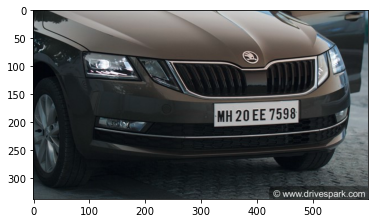

In [44]:
from random import randint
index=randint(0,len(images)-1)
img_path=f'{IMAGES_DIR_PATH}/Cars{index}.png'

print(f"index: {index}")
print(f"image: {img_path}")

im = Image.open(img_path)
width,height= im.size

print(f"width: {width}, height: {height}")

import cv2
img=cv2.imread(img_path)
plt.imshow(img)

In [18]:
# img.shape

#To view the image using opencv
# cv2.imshow("image0",img)
# cv2.waitKey(0)
# cv2.destroyAllWindows()

In [13]:
# import xml.etree.ElementTree as ET


# root=ET.parse(xmls[index]).getroot()

# ob=root.find('object')

# xmin=int(ob.find('bndbox/xmin').text)
# ymin=int(ob.find('bndbox/ymin').text)
# xmax=int(ob.find('bndbox/xmax').text)
# ymax=int(ob.find('bndbox/ymax').text)

# box=[xmin, ymin, xmax, ymax]




C:\Users\HP\Desktop\ML\ANPR\yolov5


YOLOv5  70e617d torch 1.8.1+cpu CPU

Model Summary: 224 layers, 7053910 parameters, 0 gradients, 16.3 GFLOPS


Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.25, device='', exist_ok=True, img_size=640, iou_thres=0.45, name='exp', nosave=False, project='runs/detect', save_conf=False, save_txt=True, source='.././random-cars-dataset/images/Cars111.png', update=False, view_img=False, weights=['./runs/train/exp2/weights/best.pt'])
Fusing layers... 
image 1/1 C:\Users\HP\Desktop\ML\ANPR\yolov5\..\random-cars-dataset\images\Cars111.png: 384x640 1 license_plate, Done. (0.275s)
Results saved to runs\detect\exp
5 labels saved to runs\detect\exp\labels
Done. (0.308s)
321 157 482 215
C:\Users\HP\Desktop\ML\ANPR


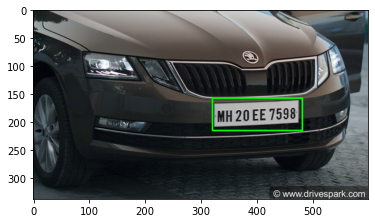

In [45]:
%cd yolov5
!python detect.py --weights ./runs/train/exp2/weights/best.pt --source ../{img_path} --save-txt --exist-ok

#get yolov5 label and get the bounding box
label_file=open(f'./runs/detect/exp/labels/Cars{index}.txt')
s=label_file.readline().replace('\n','').split(' ')
s=[ float(i) for i in s]

bottom_x=((2*s[1]+s[3])/2)
top_x=bottom_x-s[3]

bottom_y=((2*s[2]+s[4])/2)
top_y=bottom_y-s[4]

top_x=int(top_x*width)
bottom_x=int(bottom_x*width)

top_y=int(top_y*height)
bottom_y=int(bottom_y*height)

print(f'{top_x} {top_y} {bottom_x} {bottom_y}')

img=cv2.rectangle(img,(top_x,top_y),(bottom_x,bottom_y),(0,255,0),2)
plt.imshow(img)

%cd ..

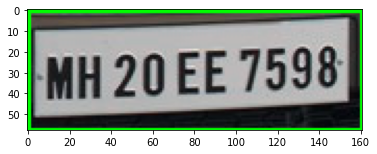

In [47]:
img_crop=img[top_y:bottom_y,top_x:bottom_x]

plt.imshow(img_crop)

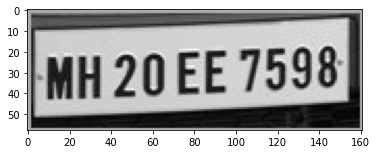

In [55]:
img_gray=cv2.cvtColor(img_crop, cv2.COLOR_BGR2GRAY)
plt.imshow(img_gray,cmap="gray")

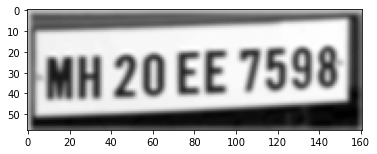

In [57]:
img_blur = cv2.GaussianBlur(img_gray, (5,5), 0)
plt.imshow(img_blur,cmap="gray")

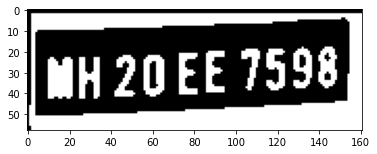

In [58]:
img_bw=cv2.threshold(img_blur, 0, 255, cv2.THRESH_OTSU | cv2.THRESH_BINARY_INV)[1]
plt.imshow(img_bw, cmap="gray")

In [51]:
contours,_=cv2.findContours(img_bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

print(len(contours))

16


In [59]:
pytesseract.pytesseract.tesseract_cmd =r'/usr/bin/tesseract'

In [60]:
# from pytesseract import image_to_string as im_2_st
from pytesseract import image_to_string
# from google.colab.patches import cv2_imshow

answer=""
for cont in contours:
    x,y,w,h=cv2.boundingRect(cont)
    
    img_h,img_w=img_bw.shape
    
    
    ratio = h / float(w)
    if ratio < 1.5:
      # print("r "+str(ratio))
      continue
        
    area = h * w
    if area < 100:
      # print("a "+str(area))
      continue
        
    roi=img_bw[y:y+h,x:x+w]
    
    roi=cv2.copyMakeBorder(roi,5,5,5,5,cv2.BORDER_CONSTANT,value=[0,0,0])
    text=image_to_string(roi,config='-c tessedit_char_whitelist=0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ --psm 8 --oem 3')
    answer+=text[0]

    cv2.imshow(roi)
    
    
print(answer)

TesseractNotFoundError: /usr/bin/tesseract is not installed or it's not in your PATH. See README file for more information.